## FC-nets for multiprotein stability predictions.
- Work within the `notebooks` directory

## Step 1: Connect to gdrive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Imports and installation.
- Probably biopython should be installed, and in some cases keras/tensorflow. The rest should be available out of the box. Installation statements are commented to be used in case not working.

In [4]:
import pandas as pd
import numpy as np
import pickle
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns

# installation of these seems not to be necessary
# pip install tensorflow==1.13.2
# pip install tensorflow-gpu==1.13.2

In [6]:
!pip install biopython

     |████████████████████████████████| 2.3MB 6.0MB/s 


In [7]:
import keras
from keras import Input
from keras.layers import Dense
import pandas as pd
import numpy as np

# if not install please try one of these
# pip install tensorflow==1.13.2
# pip install tensorflow-gpu==1.13.2
# pip install keras

import pandas as pd
import numpy as np
import Bio.PDB
from os.path import exists
## utils import and function
import pandas as pd
import numpy as np


In [8]:
import os
from os.path import exists, join

# output and figures will be saved here.
output_dir = '../models_and_figures'
if not os.path.exists(output_dir):
  os.mkdir(output_dir)

## Move to working directory and data loading from repository.

In [9]:
cd "/content/gdrive/MyDrive/colab/stability_prediction_hackathon/hackathon_2021_protein_stability/notebooks"

/content/gdrive/MyDrive/colab/stability_prediction_hackathon/hackathon_2021_protein_stability/notebooks


## Step 2: Load the data files for single mutation (already one-hot encoded).

In [10]:
df_train_multiple = pd.read_csv('../data/multiple_muts_train_onehot.csv.gz', compression='gzip', index_col=0)
X_mult = np.array(df_train_multiple['Sequence_onehot'])
y_mult = df_train_multiple['stabilityscore']
X_mult = X_mult[~np.isnan(y_mult)]
y_mult = y_mult[~np.isnan(y_mult)]
df_train_single['single'] = 1


In [58]:
df_train_single = pd.read_csv('../data/single_muts_train_onehot.csv.gz', compression='gzip', index_col=0)
df_train_single = df_train_single[~pd.isnull(df_train_single.index)]
X_mult = np.array(df_train_multiple['Sequence_onehot'])
y_mult = df_train_multiple['stabilityscore']
X_mult = X_mult[~np.isnan(y_mult)]
y_mult = y_mult[~np.isnan(y_mult)]
df_train_multiple['single'] = 0


In [59]:
df = pd.concat([df_train_single, df_train_multiple])

These are "batches" detected in the data, that stratify stability values in ways that could potentially be used as modeling variables.

In [76]:
df['protein'] = df.index.str.split('_').str[0]
df['rep'] = df.index.str.split('_').str[1]
df.groupby(['rep', 'protein']).size()

rep       protein
0142.pdb  HHH         641
0882.pdb  EHEE        578
rd1       EEHEE      2708
          EHEE       2354
          HEEH       2364
          HHH        2338
rd2       EEHEE      3087
          EHEE       3585
          HEEH       3372
          HHH        1168
rd3       EEHEE      6889
          EHEE       1187
          HEEH       6221
          HHH        1245
dtype: int64

### A bunch of helper functions to manipulate data and plotting.

In [61]:
def get_np_from_series(series):
    result = series.apply(lambda x: 
                               np.fromstring(
                                   x.replace('\n','')
                                    .replace('[','')
                                    .replace(']','')
                                    .replace('  ',' '), sep=' '))
    return result

def get_input_features(df, sse_simple=False):
    X1 = []
    for s in df['sequence']:
        ohe = onehot_encode_aa(s)
        X1.append(ohe.flatten())
    X1 = np.array(X1)

    
    X2 = []
    if not sse_simple:
        X2 = []
        for s in df['secondary_structure']:
            ohe = onehot_encode_ss(s)
            X2.append(ohe.flatten())
        X2 = np.array(X2)
    else:
        # simpler version to make X2
        ss = []
        pos_by_ss = {ssi: i for i, ssi in enumerate(df['secondary_structure'].value_counts().index)}
        for ssi in df['secondary_structure']:
            # print(ssi, pos_by_ss[ssi])
            ss.append([0 if pos_by_ss[ssi] != i else 1 for i in range(len(pos_by_ss))])
        X2 = np.array(ss)
      
    
    X3 = []
    for s in df['single']:
        X3.append(int(s))
    X3 = np.array(X3)

    X4 = []
    for s in df['rep']:
        ohe = onehot_encode_rep(s)
        X4.append(ohe.flatten())
    X4 = np.array(X4)


    return (X1, X2, X3, X4)

def get_color_ss(series_ss):
    color_by_struct = {'TEEEETTEEEETTTHHHHHHHHHHHHHHHTTTEEEETTEEEET': '#e41a1c',
                      'THHHHHHHHHHHHHTTEEEETTEEEETTTHHHHHHHHHHHHHT': '#377eb8',
                      'THHHHHHHHHHHHHTTTHHHHHHHHHHHTTTHHHHHHHHHHHT': '#4daf4a',
                      'TTTTEEEEETTHHHHHHHHHHHHHHTTTEEEEEETTEEEEEET': '#984ea3'}

    return series_ss.map(color_by_struct)

def onehot_encode_aa(sequence):
    """ Converts string-format amino acid sequence to one-hot encoded format """
    aa_indices = []
    for aa in sequence:
         try:
             aa_index = Bio.PDB.Polypeptide.one_to_index(aa)
         except:
             aa_index = 20 # account for non-standard aa
         aa_indices.append(aa_index)
    
    sequence_onehot = np.zeros((len(aa_indices), 20))
    sequence_onehot[np.arange(len(aa_indices)), aa_indices] = 1
    return sequence_onehot

def onehot_encode_ss(sequence):
    """ Converts string-format secondary structure sequence to one-hot encoded format """
    ss_dict = {"E": 0, "T": 1, "S": 2, "H": 3} # {"-": 0, 
    ss_indices = []
    for ss in sequence:
         try:
             ss_index = ss_dict[ss]
         except:
             aa_index = 20 # account for non-standard aa
         ss_indices.append(ss_index)
    
    sequence_onehot = np.zeros((len(ss_indices), len(ss_dict)))
    sequence_onehot[np.arange(len(ss_indices)), ss_indices] = 1
    return sequence_onehot

def onehot_encode_rep(sequence):
    """ Converts string-format secondary structure sequence to one-hot encoded format """
    ss_dict = {"rd1": 0, "rd2": 1, "rd3": 2, '0882.pdb': 3, '0142.pdb': 4} # {"-": 0, 
    ss_indices = []
    for ss in [sequence]:
         try:
             ss_index = ss_dict[ss]
         except:
             aa_index = 20 # account for non-standard aa
         ss_indices.append(ss_index)
    
    sequence_onehot = np.zeros((len(ss_indices), len(ss_dict)))
    sequence_onehot[np.arange(len(ss_indices)), ss_indices] = 1
    return sequence_onehot

In [75]:
# plottting
from scipy.stats import pearsonr, spearmanr
from matplotlib import rcParams
from sklearn.metrics import r2_score
def plot(model, x1, x2, x3, x4, y, color, dpi=80, figsize=[5, 5], axis='equal'):
    
    ax = plt.subplot()

    y_pred = model.predict([x1, x2, x3, x4])
    rcParams['figure.figsize'] = figsize
    rcParams['figure.dpi'] = dpi
    
    r = pearsonr(y_pred.flatten(), y)[0]
    rho = spearmanr(y_pred.flatten(), y)[0]
    r2 = r2_score(y_pred, y)
    
    pearson_title = 'Pearson=%.2f' % r
    spearman_title = '\u03C1=%.2f' % rho
    # print('xmin/xmax', min(y_pred.flatten()), max(y_pred.flatten()))

    plt.scatter(y_pred, y, c=color, s=6)
    
    if axis is not None:
        plt.axis('equal')
    
    plt.xlabel('predicted')
    plt.ylabel('measured')
    plt.title('N=%i, %s, %s' % (y.shape[0], pearson_title, spearman_title))
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    return [r, rho, r2]

    

### The actual model and train/val/test data preparation. 

In [73]:
def get_model(n_aa=860, n_ss=172, log=False):

    one_hot_input = Input(shape=(n_aa,) )
    second_hot_input = Input(shape=(n_ss,) )
    third_hot_input = Input(shape=(1,) )
    fourth_hot_input = Input(shape=(5,) )

    first_dense = Dense(n_aa)(one_hot_input)
    second_dense = Dense(n_ss)(second_hot_input)    
    third_dense = Dense(1)(third_hot_input)
    fourth_dense = Dense(5)(fourth_hot_input)

    merge_one = keras.layers.Concatenate()([first_dense, second_dense, third_dense, fourth_dense])

    dense_inner = Dense(870)(merge_one)

    dense_inner = keras.layers.Dropout(0.5)(dense_inner)
    dense_inner = Dense(435)(dense_inner)
    dense_inner = keras.layers.Dropout(0.5)(dense_inner)
    dense_inner = Dense(213)(dense_inner)
    dense_inner = keras.layers.Dropout(0.5)(dense_inner)
    dense_inner = Dense(112)(dense_inner)
    dense_inner = keras.layers.Dropout(0.5)(dense_inner)
    dense_inner = Dense(56)(dense_inner)
    dense_inner = keras.layers.Dropout(0.5)(dense_inner)    

    dense_output = Dense(1)(dense_inner)
    model = keras.Model(inputs=[one_hot_input, second_hot_input, third_hot_input, fourth_hot_input], outputs=dense_output)
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['accuracy', 'mean_squared_error'])

    if log:
      model.summary()
    return model

def prepare_train_test(df, split=False, use_simple_sse=True):
    #padded_sequences = pad_sequences(sequences, maxlen=SEQUENCE_SIZE, padding='post', truncating='post', value=0)
    print(df.shape)
    df = df[~np.isnan(df['stabilityscore'])]
    X1, X2, X3, X4 = get_input_features(df, sse_simple=use_simple_sse)
    print(X1.shape, X2.shape, X3.shape, X4.shape)
    y = np.array(df['stabilityscore'])

    print(X1.shape, X2.shape, y.shape)
    # remove nans
    X1 = X1[~np.isnan(y)]
    X2 = X2[~np.isnan(y)]
    y = y[~np.isnan(y)]

    if split:
        x_train, x_val, y_train, y_val = train_test_split(pd.DataFrame(np.concatenate([X1, X2, X3.reshape(X1.shape[0], 1), X4], axis=1)), y, test_size=0.25)    
        idx_train = x_train.index
        idx_val = x_val.index
        x_train = np.array(x_train)
        x_val = np.array(x_val)
        return x_train, x_val, y_train, y_val, idx_train, idx_val
    else:
        X_test = np.concatenate([X1, X2, X3.reshape(X1.shape[0], 1), X4], axis=1)
        return X_test, y


## Here all queries for training/testing are done with a grid of parameters, user defined from the queries dataframe.
- use_all: train with all single+multiple training data (True) or only single mutants (False).
- use_simple_see: Encode all details from SSE into 172 features (43 * 4, False), or only use minimal_protein_class (4, True).
- n_epochs: training runtime.

In [ ]:
# queries statements
use_all = [False, True]
use_simple_sse = [False, True]
n_epochs = [3, 10, 50]
queries = [[a, b, c] for c in n_epochs for a in use_all for b in use_simple_sse]

queries = pd.DataFrame(queries, columns=['use.all', 'use.simple.sse', 'n.epochs'])
queries

In [110]:
overwrite = False

n_aa = 860
n_type = 1
n_rep = 5

res = []
for qi, q in queries.iterrows():
    model = None
    
    use_all, use_simple_sse, n_epochs = q.values
    print('next...')         
    print(q)

    bkp_path_single = join(output_dir, 'model_%s_%s_%i_epochs.h5' % ('singlendouble' if use_all else 'single', 'ssecomplex' if not use_simple_sse else 'ssesimple', n_epochs))
    print(exists(bkp_path_single), bkp_path_single)

    # the number of sse elements is flexible
    n_ss = 4 if use_simple_sse else 172

    shapes = [n_aa, n_ss, n_type, n_rep]
    model = get_model(n_aa=860, n_ss=4 if use_simple_sse else 172)
    
    df = df_train_single if not use_all else pd.concat([df_train_single, df_train_multiple]).copy()
    
    df['idx'] = np.arange(df.shape[0])
    df['protein'] = df.index.str.split('_').str[0]
    df['rep'] = df.index.str.split('_').str[1]

    x_train, x_val, y_train, y_val, idx_train, idx_val = prepare_train_test(df, split=True, use_simple_sse=use_simple_sse)

    x1_train = x_train[:,:n_aa]
    x2_train = x_train[:,n_aa:n_aa + n_ss]        
    x3_train = x_train[:,n_aa + n_ss:n_aa + n_ss + n_type]
    x4_train = x_train[:,n_aa + n_ss + n_type:]
    
    x1_val = x_val[:,:n_aa]
    x2_val = x_val[:,n_aa:n_aa + n_ss]        
    x3_val = x_val[:,n_aa + n_ss:n_aa + n_ss + n_type]
    x4_val = x_val[:,n_aa + n_ss + n_type:]
    
    
    print('train shapes')
    print(x1_train.shape, x2_train.shape, x3_train.shape, x3_train.shape)
    print('val shapes')
    print(x1_val.shape, x2_val.shape, x3_val.shape, x4_val.shape)

    if not exists(bkp_path_single) or overwrite:
      model.fit([x1_train, x2_train, x3_train, x4_train], y_train, epochs=n_epochs,
      validation_data=([x1_val, x2_val, x3_val, x4_val], y_val))
      print('saving...')
      model.save(bkp_path_single)

    print('loading...')    
    model = keras.models.load_model(bkp_path_single)    

    from matplotlib import rcParams
    import matplotlib.pyplot as plt
    ### model evaluation in single mut data
    df_test = pd.read_csv('../data/single_muts_test.csv')
    df_test['single'] = 1
    df_test = df_test[~np.isnan(df_test['stabilityscore'])]
    df_test['protein'] = df_test['name'].str.split('_').str[0]
    df_test['rep'] = df_test['name'].str.split('_').str[1]
    df_test = df_test[df_test['rep'].str.contains('rd')]

    x_test, y_test = prepare_train_test(df_test, split=False)

    x1_test = x_test[:,:n_aa]
    x2_test = x_test[:,n_aa:n_aa + n_ss]        
    x3_test = x_test[:,n_aa + n_ss:n_aa + n_ss + n_type]
    x4_test = x_test[:,n_aa + n_ss + n_type:]

    # plot training
    rcParams['figure.figsize'] = [5, 5]
    color = get_color_ss(df[df['idx'].isin(idx_train)]['secondary_structure']).values
    r, rho, r2 = plot(model, x1_train, x2_train, x3_train, x4_train, y_train,
                      color=color, dpi=120)
    plt.savefig(bkp_path_single.replace('.h5', '_single.train.png'))
    plt.close()

    res.append([use_all, use_complex_sse, n_epochs, 'single.train'] + [r, rho, r2] + shapes)

    # test data (single mutants)
    df_test = pd.read_csv('../data/single_muts_test.csv')
    df_test = df_test[~np.isnan(df_test['stabilityscore'])]
    df_test['single'] = 1
    df_test['protein'] = df_test['name'].str.split('_').str[0]
    df_test['rep'] = df_test['name'].str.split('_').str[1]
    # df_test = df_test[df_test['rep'].str.contains('rd')]


    x_test, y_test = prepare_train_test(df_test, split=False, use_simple_sse=use_simple_sse)

    x1_test = x_test[:,:n_aa]
    x2_test = x_test[:,n_aa:n_aa + n_ss]        
    x3_test = x_test[:,n_aa + n_ss:n_aa + n_ss + n_type]
    x4_test = x_test[:,n_aa + n_ss + n_type:]

    r, rho, r2 = plot(model, x1_test, x2_test, x3_test, x4_test, y_test,
                      color=get_color_ss(df_test['secondary_structure']).values, dpi=120)
    plt.savefig(bkp_path_single.replace('.h5', '_single.test.png'))
    plt.close()

    res.append([use_all, use_complex_sse, n_epochs, 'single.test'] + [r, rho, r2] + shapes)


    # multiple mutants
    df_test = pd.read_csv('../data/multiple_muts_train_onehot.csv.gz', compression='gzip', index_col=0)
    df_test['single'] = 0
    df_test = df_test[~np.isnan(df_test['stabilityscore'])]
    df_test['protein'] = df_test.index.str.split('_').str[0]
    df_test['rep'] = df_test.index.str.split('_').str[1]
    # df_test = df_test[df_test['rep'].str.contains('rd')]

    x1_test, x2_test, x3_test, x4_test = get_input_features(df_test, sse_simple=use_simple_sse)

    y_test = df_test['stabilityscore']
    # type(np.array(X[0]))
    y_test = y_test[~np.isnan(y_test)]

    r, rho, r2 = plot(model, x1_test, x2_test, x3_test, x4_test, y_test,
                      color=get_color_ss(df_test['secondary_structure']).values,
                      axis=None, dpi=150)

    plt.xlim([-.6, .6])
    plt.savefig(bkp_path_single.replace('.h5', '_mult.test.png'))
    plt.close()

    print('\n\n')

    res.append([use_all, use_simple_sse, n_epochs, 'mult.test'] + [r, rho, r2] + shapes)

next...
use.all           False
use.simple.sse    False
n.epochs              3
Name: 0, dtype: object
True ../models_and_figures/model_single_ssecomplex_3_epochs.h5
(8550, 11)
(8550, 860) (8550, 172) (8550,) (8550, 5)
(8550, 860) (8550, 172) (8550,)
train shapes
(6412, 860) (6412, 172) (6412, 1) (6412, 1)
val shapes
(2138, 860) (2138, 172) (2138, 1) (2138, 5)
loading...
(1861, 8)
(1861, 860) (1861, 4) (1861,) (1861, 5)
(1861, 860) (1861, 4) (1861,)
color ['#984ea3' '#984ea3' '#e41a1c' '#e41a1c' '#e41a1c']
(2138, 8)
(2138, 860) (2138, 172) (2138,) (2138, 5)
(2138, 860) (2138, 172) (2138,)
color ['#e41a1c' '#984ea3' '#e41a1c' '#e41a1c' '#377eb8']
color ['#984ea3' '#984ea3' '#377eb8' '#e41a1c' '#e41a1c']



next...
use.all           False
use.simple.sse     True
n.epochs              3
Name: 1, dtype: object
True ../models_and_figures/model_single_ssesimple_3_epochs.h5
(8550, 11)
(8550, 860) (8550, 4) (8550,) (8550, 5)
(8550, 860) (8550, 4) (8550,)
train shapes
(6412, 860) (6412, 4) (641

In [114]:
### Save the results collected from the multiquery run
res = pd.DataFrame(res, columns=['use.all', 'use_simple_sse', 'n.epochs', 'label',
                                 'r', 'rho', 'r2', 'n.aa', 'n.sse', 'n.type', 'n.batch'])
res.to_csv('../data/results.csv')

### Visualize for best models and approaches.

In [103]:
ls ../models_and_figures/*50_epochs*.png

../models_and_figures/model_singlendouble_ssecomplex_50_epochs_mult.test.png
../models_and_figures/model_singlendouble_ssecomplex_50_epochs_single.test.png
../models_and_figures/model_singlendouble_ssecomplex_50_epochs_single.train.png
../models_and_figures/model_singlendouble_ssesimple_50_epochs_mult.test.png
../models_and_figures/model_singlendouble_ssesimple_50_epochs_single.test.png
../models_and_figures/model_singlendouble_ssesimple_50_epochs_single.train.png
../models_and_figures/model_single_ssecomplex_50_epochs_mult.test.png
../models_and_figures/model_single_ssecomplex_50_epochs_single.test.png
../models_and_figures/model_single_ssecomplex_50_epochs_single.train.png
../models_and_figures/model_single_ssesimple_50_epochs_mult.test.png
../models_and_figures/model_single_ssesimple_50_epochs_single.test.png
../models_and_figures/model_single_ssesimple_50_epochs_single.train.png


In [116]:
# best results by architecture combination
res = pd.read_csv('../data/results.csv', index_col=0)
res['use_simple_sse'] = res['n.sse'] == 4
res['k.full'] = res['label'] + '.' + np.where(res['use.all'], 'all', 'single')
res.sort_values('r', ascending=False).drop_duplicates('k.full')

,use.all,use_simple_sse,n.epochs,label,r,rho,r2,n.aa,n.sse,n.type,n.batch,k.full
24,False,False,50,single.train,0.860030,0.857706,0.293942,860,172,1,5,single.train.single
25,False,False,50,single.test,0.833648,0.834499,0.218555,860,172,1,5,single.test.single
9,True,True,3,single.train,0.797772,0.687279,0.303138,860,4,1,5,single.train.all
34,True,True,50,single.test,0.765314,0.773432,-7.441584,860,4,1,5,single.test.all
11,True,True,3,mult.test,0.469882,0.374671,-1.843358,860,4,1,5,mult.test.all
29,False,True,50,mult.test,0.230809,0.181938,-1.909362,860,4,1,5,mult.test.single


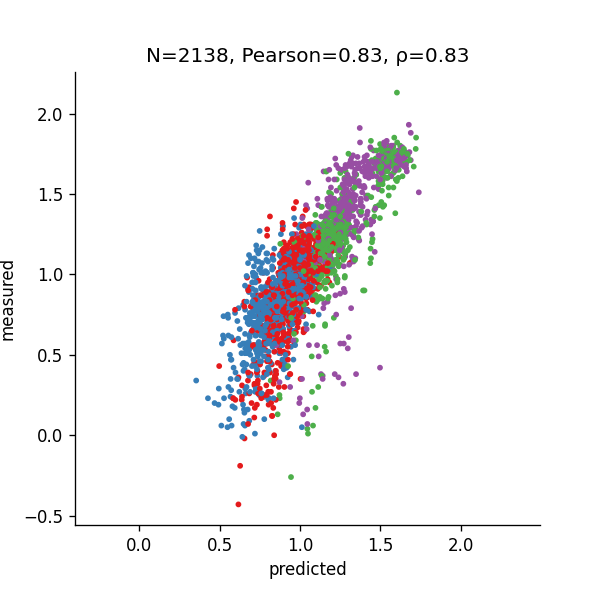

In [111]:
# best single mutant prediction
from IPython.display import Image
Image('../models_and_figures/model_single_ssecomplex_50_epochs_single.test.png')

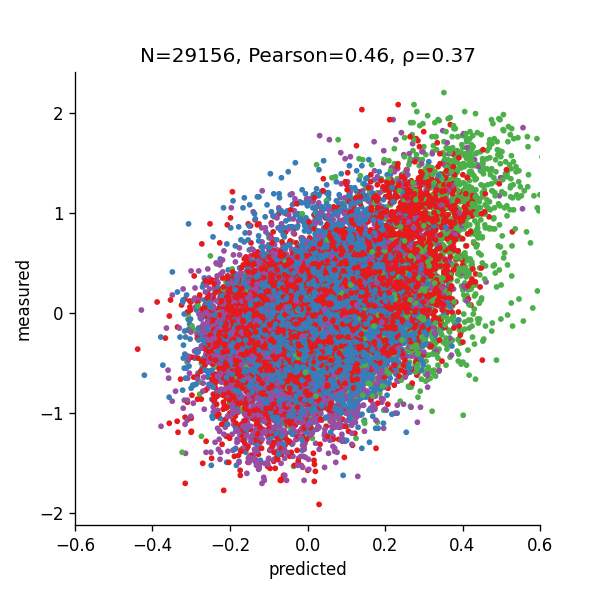

In [112]:
# best double mutant prediction
from IPython.display import Image
Image('../models_and_figures/model_singlendouble_ssesimple_50_epochs_mult.test.png')

single.test (4, 13)


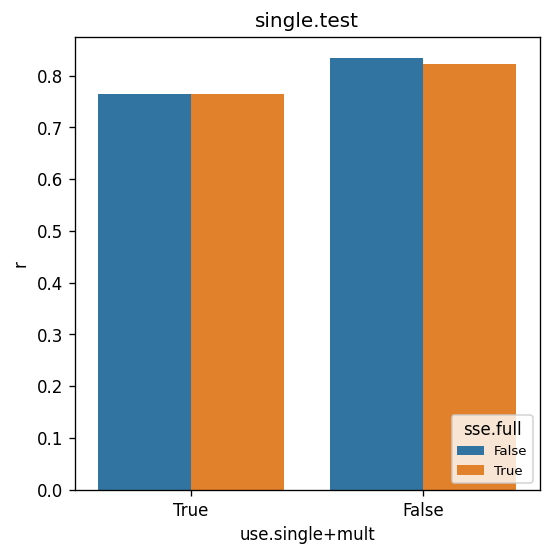

In [95]:
label = 'single.test'
grp = res[(res['label'] == 'single.test') & (res['n.epochs'] == 50)]

rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 120

print(label, grp.shape)
sns.barplot(data=grp, x='use.all', hue='use_simple_sse', y='r', order=[True, False])
plt.xlabel('use.single+mult')
plt.title(label)
plt.legend(fontsize=8, loc='lower right', title='sse.full')

In [97]:
grp

,use.all,use.complex,n.epochs,label,r,rho,r2,n.aa,n.sse,n.type,n.batch,use_simple_sse,k.full
26,False,True,50,mult.test,0.208747,0.156750,-5.943244,860,172,1,5,False,mult.test.single
29,False,True,50,mult.test,0.230809,0.181938,-1.909362,860,4,1,5,True,mult.test.single
32,True,True,50,mult.test,0.457393,0.366405,-1.915600,860,172,1,5,False,mult.test.all
35,True,True,50,mult.test,0.455049,0.373438,-9.025430,860,4,1,5,True,mult.test.all


In [99]:
grp

,use.all,use.complex,n.epochs,label,r,rho,r2,n.aa,n.sse,n.type,n.batch,use_simple_sse,k.full
26,False,True,50,mult.test,0.208747,0.156750,-5.943244,860,172,1,5,False,mult.test.single
29,False,True,50,mult.test,0.230809,0.181938,-1.909362,860,4,1,5,True,mult.test.single
32,True,True,50,mult.test,0.457393,0.366405,-1.915600,860,172,1,5,False,mult.test.all
35,True,True,50,mult.test,0.455049,0.373438,-9.025430,860,4,1,5,True,mult.test.all


mult.test (4, 13)


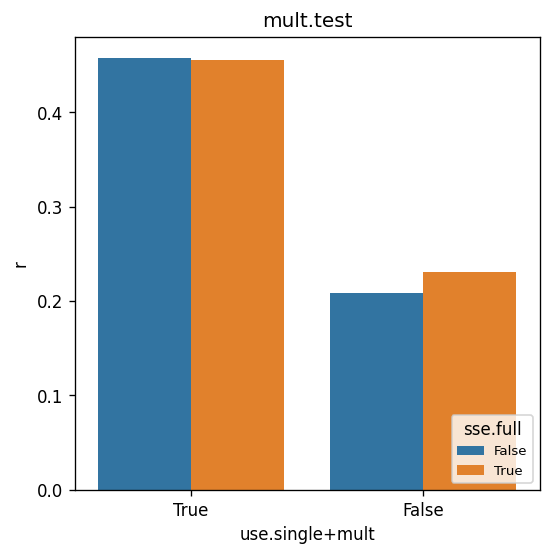

In [100]:
label = 'mult.test'
grp = res[(res['label'] == label) & (res['n.epochs'] == 50)]

rcParams['figure.figsize'] = 5, 5
print(label, grp.shape)
sns.barplot(data=grp, x='use.all', hue='use_simple_sse', y='r', order=[True, False])
plt.xlabel('use.single+mult')
plt.title(label)
plt.legend(fontsize=8, loc='lower right', title='sse.full')

mult.test.all (4, 8)
mult.test.single (4, 8)
single.test.all (4, 8)
single.test.single (4, 8)
single.train.all (4, 8)
single.train.single (4, 8)


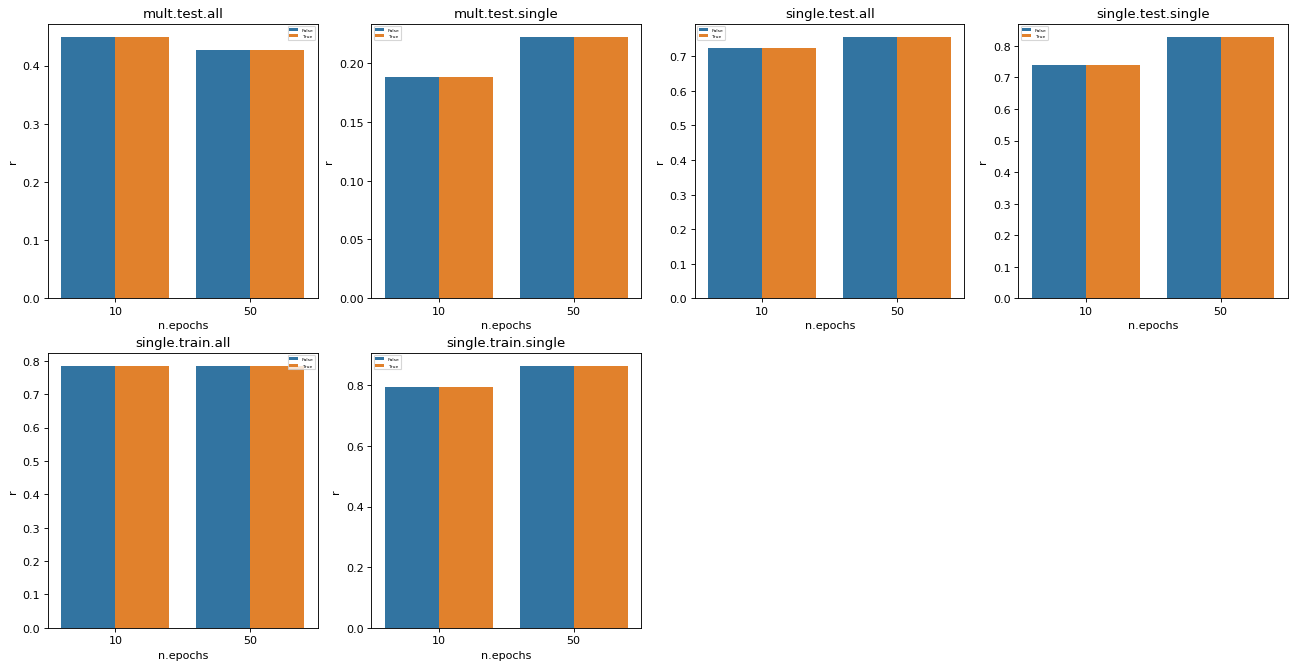

In [ ]:
rcParams['figure.figsize'] = 20, 10
pi = 0
for label, grp in res.groupby('k.full'):
    plt.subplot(2, 4, pi + 1)
    print(label, grp.shape)
    sns.barplot(data=grp, x='n.epochs', hue='use.complex', y='r')
    plt.title(label)
    plt.legend(fontsize=4)
    pi += 1

### Testing data (single mutants)